In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [16]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [91]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [92]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [93]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

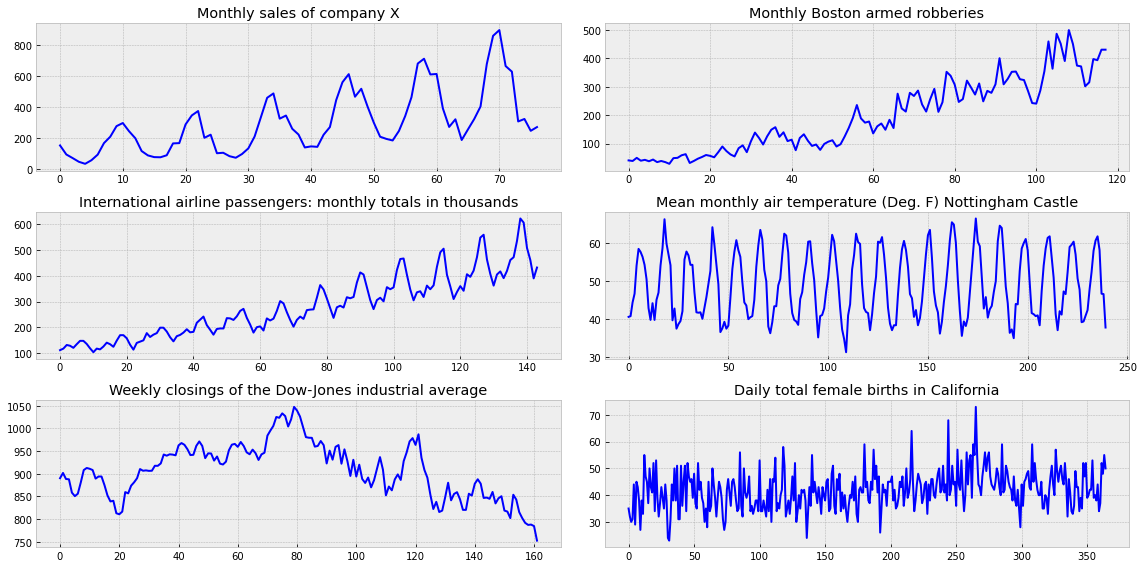

In [94]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [95]:
for i in all_series.keys():
    print(i)
    test_stationarity(all_series[i])
    print()

Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64

Monthly Boston armed robberies
Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64

International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critic

In [96]:
# видим что у ряда Daily total female births in California уже все хорошо. Убираем его из дальнейших операций
del all_series['Daily total female births in California']

In [97]:
# массово делаем преобразование бокса-кокса для убирания дисперсии
all_series_bc = {}

for i in all_series.keys():
    all_series_bc[i] = pd.Series(boxcox(all_series[i], 0))
    print(i)
    test_stationarity(all_series_bc[i])
    print()


Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64

Monthly Boston armed robberies
Results of Dickey-Fuller Test:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64

International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critic

In [98]:
# Судя по тесту дики-фуллера у ряда Mean monthly air temperature (Deg. F) Nottingham Castle тоже стало все хорошо, убираем его
del all_series_bc['Mean monthly air temperature (Deg. F) Nottingham Castle']

In [99]:
# тренд виден у трёх рядов, уберем его дифференцированием
keysd = ['Monthly Boston armed robberies', 'International airline passengers: monthly totals in thousands', 
         'Monthly sales of company X']

for i in keysd:
    s = np.asarray(all_series_bc[i])
    dif = s[1:] - s[:-1]
    all_series_bc[i] = pd.Series(dif[12:] - dif[:-12])

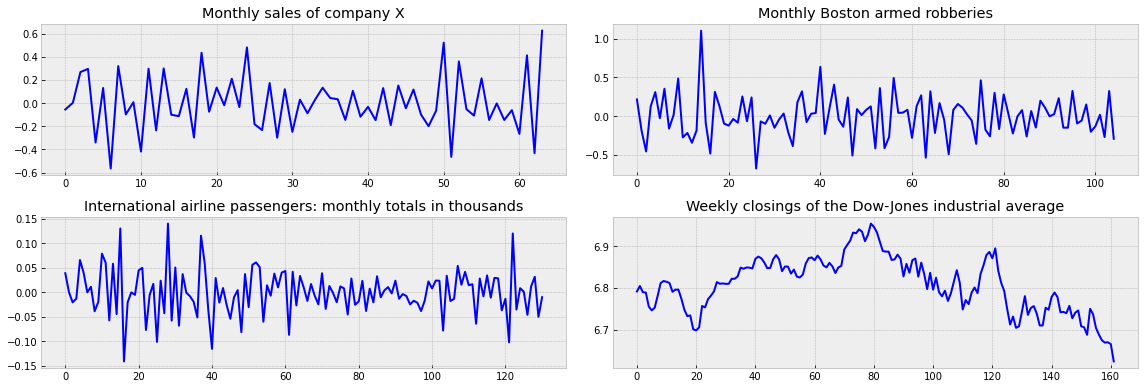

In [100]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series_bc.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series_bc[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [101]:
for i in all_series_bc.keys():
    print(i)
    test_stationarity(all_series_bc[i])
    print()

Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                 -2.316045
p-value                         0.166845
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64

Monthly Boston armed robberies
Results of Dickey-Fuller Test:
Test Statistic                 -4.232984
p-value                         0.000579
#Lags Used                     13.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64

International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Valu

In [111]:
# теперь хорошо везде, кроме Weekly closings of the Dow-Jones industrial average
# попробуем его тоже дифференцировать
s = np.asarray(all_series_bc['Weekly closings of the Dow-Jones industrial average'])
new = s[1:] - s[:-1]
all_series_bc['Weekly closings of the Dow-Jones industrial average new'] = pd.Series(new)


In [113]:
# готово. Все ряды - стационарные
test_stationarity(all_series_bc['Weekly closings of the Dow-Jones industrial average new'])

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64
